In [1]:
import pandas as pd
import numpy as np
import pylab as pl
%pylab inline
import geopandas as gpd
import scipy.stats 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import mplleaflet

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Importing 311 data
#Source: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9
data_311 = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv')
data_311 = data_311[['Unique Key', 'Created Date', 'Complaint Type', 'Descriptor', 
                     'Incident Zip', 'Borough']]
data_311 = data_311.replace('Mouse Sighting', 'Rat Sighting')
data_311 = data_311.rename(columns = {'Incident Zip':'ZIP'})
data_311['Year'] = pd.DatetimeIndex(data_311['Created Date']).year
data_311r = data_311[data_311['Year']>=2014]                                    
data_311.head()

/usr/local/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (17,21) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


,Unique Key,Created Date,Complaint Type,Descriptor,ZIP,Borough,Year
0,32154713,12/08/2015 12:39:42 AM,Rodent,Rat Sighting,11211,BROOKLYN,2015
1,32153645,12/08/2015 12:36:56 AM,Rodent,Rat Sighting,10001,MANHATTAN,2015
2,32151473,12/07/2015 11:38:19 PM,Rodent,Rat Sighting,10011,MANHATTAN,2015
3,32148435,12/07/2015 11:16:31 PM,Rodent,Rat Sighting,11237,BROOKLYN,2015
4,32149313,12/07/2015 11:15:35 PM,Rodent,Rat Sighting,11210,BROOKLYN,2015


In [3]:
#Importing ZCTA code file
#https://www.census.gov/geo/maps-data/data/zcta_rel_download.html
data_zcta = pd.read_csv('zcta_tract_rel_10.txt')
data_zcta = data_zcta.rename(columns = {'GEOID':'GEO.id2'})
data_zcta['GEO.id2'] = data_zcta['GEO.id2'].apply(str)
data_zcta.head() #GEO.id2 > ZCTA5

,ZCTA5,STATE,COUNTY,TRACT,GEO.id2,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,...,TRAREA,TRAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,TRPOPPCT,TRHUPCT,TRAREAPCT,TRAREALANDPCT
0,601,72,1,956300,72001956300,4271,1706,44663250,44572589,18570,...,44924558,44833897,23.00,22.03,26.67,26.74,98.5,98.33,99.42,99.42
1,601,72,1,956400,72001956400,2384,1037,32830481,32492074,18570,...,37782601,37191697,12.84,13.39,19.61,19.50,79.6,80.14,86.89,87.36
2,601,72,1,956500,72001956500,3126,1240,44969548,44809680,18570,...,44969548,44809680,16.83,16.01,26.85,26.89,100.0,100.00,100.00,100.00
3,601,72,1,956600,72001956600,2329,972,1981101,1981101,18570,...,1981101,1981101,12.54,12.55,1.18,1.19,100.0,100.00,100.00,100.00
4,601,72,1,956700,72001956700,2053,948,1380041,1380041,18570,...,1380041,1380041,11.06,12.24,0.82,0.83,100.0,100.00,100.00,100.00


In [4]:
#Creating ZCTA dictionary
zcta_dict = {}
for i in range(len(data_zcta)):
    zcta_dict[data_zcta['GEO.id2'][i]] = data_zcta['ZCTA5'][i]

In [5]:
#Importing 2014 Census data
#Source: http://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml
data_census14 = pd.read_csv('ACS_14_5YR_B19013/ACS_14_5YR_B19013.csv')
data_census14 = data_census14.rename(columns = {'HD01_VD01':'Median Household Income 2014'})
data_census14['ZCTA'] = data_census14['GEO.id2'].map(zcta_dict)
data_census14 = data_census14[data_census14.index>0]
data_census14 = data_census14[['ZCTA', 'Median Household Income 2014']]
data_census14 = data_census14[~pd.isnull(data_census14['Median Household Income 2014'])]
data_census14['Median Household Income 2014'] = data_census14['Median Household Income 2014'].apply(int)
data_census14 = data_census14.groupby(['ZCTA']).mean()
data_census14['ZCTA'] = data_census14.index
data_census14.index = range(len(data_census14))
data_census14.head()

,Median Household Income 2014,ZCTA
0,121552.500000,10001
1,42595.461538,10002
2,106134.125000,10003
3,170455.000000,10005
4,122031.000000,10007


In [6]:
#Importing 2009 Census data
#Source: http://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml
data_census09 = pd.read_csv('ACS_09_5YR_B19013/ACS_09_5YR_B19013.csv')
data_census09 = data_census09.rename(columns = {'HD01_VD01':'Median Household Income 2009'})
data_census09['GEO.id2'] = data_census09['GEO.id2'].apply(str)
data_census09['ZCTA'] = data_census09['GEO.id2'].map(zcta_dict)
data_census09 = data_census09[['ZCTA', 'Median Household Income 2009']]
data_census09 = data_census09[~pd.isnull(data_census09['Median Household Income 2009'])]
data_census09['Median Household Income 2009'] = data_census09['Median Household Income 2009'].apply(int)
data_census09 = data_census09.groupby(['ZCTA']).mean()
data_census09['ZCTA'] = data_census09.index
data_census09.index = range(len(data_census09))
data_census09.head()

,Median Household Income 2009,ZCTA
0,81945.000000,10001
1,38442.692308,10002
2,88769.250000,10003
3,118269.000000,10005
4,109167.000000,10007


In [7]:
#Merging 2009 and 2014 Census data
data_census = pd.merge(data_census14, data_census09, on=['ZCTA']) 
data_census.head()

,Median Household Income 2014,ZCTA,Median Household Income 2009
0,121552.500000,10001,81945.000000
1,42595.461538,10002,38442.692308
2,106134.125000,10003,88769.250000
3,170455.000000,10005,118269.000000
4,122031.000000,10007,109167.000000


In [8]:
#Loading zip codes data
#http://www.udsmapper.org/zcta-crosswalk.cfm
data_zipcodes = pd.read_excel('zip_to_zcta_2015.xlsx')
data_zipcodes = data_zipcodes[['ZIP','ZCTA']]
data_zipcodes.head()

,ZIP,ZCTA
0,96916,96916
1,96917,96917
2,96928,96928
3,96915,96915
4,96923,96913


In [9]:
#Including ZIP code in Census in Census data
census_zip = pd.merge(data_census, data_zipcodes, on=['ZCTA'])
census_zip = census_zip[['ZIP', 'Median Household Income 2009', 'Median Household Income 2014']]
census_zip = census_zip.groupby(['ZIP']).mean()
census_zip['ZIP'] = census_zip.index
census_zip.index = range(len(census_zip['ZIP']))
census_zip.head()

,Median Household Income 2009,Median Household Income 2014,ZIP
0,83636.000000,84085.666667,501
1,83636.000000,84085.666667,544
2,81945.000000,121552.500000,10001
3,38442.692308,42595.461538,10002
4,88769.250000,106134.125000,10003


In [10]:
#Importing population data
pop_zip = pd.read_csv('Census_2010.csv')
pop_zip = pop_zip[['Zipcode', 'Total']]
pop_zip = pop_zip.rename(columns = {'Zipcode':'ZIP'})
pop_zip = pop_zip.rename(columns = {'Total':'Population'})
pop_zip = pop_zip.groupby(['ZIP']).sum()
pop_zip['ZIP'] = pop_zip.index
pop_zip.index = range(0,len(pop_zip))
pop_zip['ZIP'] = pop_zip['ZIP'].apply(int)
pop_zip.head()

,Population,ZIP
0,21102,10001
1,81410,10002
2,56024,10003
3,3089,10004
4,7135,10005


In [11]:
#Loading MapPLUTO data
bk_mappluto = gpd.GeoDataFrame.from_file("Brooklyn/BKMapPLUTO.shp")
mn_mappluto = gpd.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")

In [12]:
data_mappluto =  gpd.GeoDataFrame(pd.concat([mn_mappluto, bk_mappluto], ignore_index=True))
data_mappluto = data_mappluto.rename(columns = {'ZipCode':'ZIP'})
print data_mappluto.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [13]:
#Extracting 'Year Built'
year_zip = data_mappluto[['ZIP', 'YearBuilt']]
year_zip = year_zip[year_zip['YearBuilt']>0]
year_zip = year_zip[year_zip['ZIP']>0]
year_zip = year_zip.groupby(['ZIP']).mean()
year_zip['ZIP'] = year_zip.index
year_zip.index = range(0,len(year_zip))
year_zip['YearBuilt'] = np.round(year_zip['YearBuilt'])
print len(year_zip)
year_zip.head()

93


,YearBuilt,ZIP
0,1926,10001
1,1920,10002
2,1915,10003
3,1929,10004
4,1934,10005


In [14]:
#Calculating complaints by ZIP
complaints_zip = pd.DataFrame(data_311['Unique Key'].groupby(data_311['ZIP']).count())
complaints_zip['ZIP'] = complaints_zip.index
complaints_zip.index = range(0,len(complaints_zip))
complaints_zip = complaints_zip.rename(columns = {'Unique Key':'Total Complaints'})

complaints_zipr = pd.DataFrame(data_311r['Unique Key'].groupby(data_311['ZIP']).count())
complaints_zipr['ZIP'] = complaints_zipr.index
complaints_zipr.index = range(0,len(complaints_zipr))
complaints_zipr = complaints_zipr.rename(columns = {'Unique Key':'Complaints 2014-15'})

#Sighting vs. conditions correlation
df_sight = data_311[data_311['Descriptor'] == 'Rat Sighting']
df_sight = pd.DataFrame(df_sight['Unique Key'].groupby(df_sight['ZIP']).count())
df_sight['ZIP'] = df_sight.index
df_sight.index = range(0,len(df_sight))
df_sight = df_sight.rename(columns = {'Unique Key':'Rat Sighting'})
complaints_zip = pd.merge(complaints_zip, df_sight, on=['ZIP'])

df_cond = data_311[data_311['Descriptor'] == 'Condition Attracting Rodents']
df_cond = pd.DataFrame(df_cond['Unique Key'].groupby(df_cond['ZIP']).count())
df_cond['ZIP'] = df_cond.index
df_cond.index = range(0,len(df_cond))
df_cond = df_cond.rename(columns = {'Unique Key':'Condition Attracting Rodents'})
complaints_zip = pd.merge(complaints_zip, df_cond, on=['ZIP'])

complaints_zip.head()

,Total Complaints,ZIP,Rat Sighting,Condition Attracting Rodents
0,446,10001,336,78
1,1533,10002,1047,283
2,886,10003,663,169
3,50,10004,36,8
4,26,10005,12,11


In [15]:
#Loading NYC map as Geopandas 
#http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981
nyc_map = gpd.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
nyc_map = nyc_map.rename(columns = {'postalCode':'ZIP'})
nyc_map['ZIP'] = nyc_map['ZIP'].apply(int)

In [16]:
#Creating area df
area_zip = nyc_map[['Shape_Area', 'ZIP']]
area_zip['Shape_Area'] = area_zip['Shape_Area']/1000000 
area_zip.head()

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Shape_Area,ZIP
0,20.163284,11372
1,22.606527,11004
2,6.269333,11040
3,49.418364,11426
4,69.385866,11365


In [17]:
#Merging all ZIP data
df = pd.merge(census_zip, area_zip, on=['ZIP'])
df = pd.merge(df, pop_zip, on=['ZIP'])
df = pd.merge(df, complaints_zip, on=['ZIP'])
df = pd.merge(df, complaints_zipr, on=['ZIP'])
df = pd.merge(df, year_zip, on=['ZIP'], how='outer')

#Adding other columns
df['Complaints Per 1,000 People'] = df['Total Complaints']/df['Population']*1000
df['Complaints 2014-15 Per 1,000 People'] = df['Complaints 2014-15']/df['Population']*1000
df['Complaints Per Km2'] = df['Total Complaints']/df['Shape_Area']
df['Population Density'] = df['Population']/df['Shape_Area']
df['Median Household Income'] = (df['Median Household Income 2014']+df['Median Household Income 2009'])/2
df['Income Growth'] = (df['Median Household Income 2014']/df['Median Household Income 2009']-1)*100
df = df[(np.isfinite(df['Median Household Income 2009'])) & (np.isfinite(df['Median Household Income 2014'])) & (np.isfinite(df['Complaints Per 1,000 People'])) & 
        (df['Complaints Per 1,000 People']<150) & (df['Population']>5000)]
print len(df)
df.head()

175


,Median Household Income 2009,Median Household Income 2014,ZIP,Shape_Area,Population,Total Complaints,Rat Sighting,Condition Attracting Rodents,Complaints 2014-15,YearBuilt,"Complaints Per 1,000 People","Complaints 2014-15 Per 1,000 People",Complaints Per Km2,Population Density,Median Household Income,Income Growth
0,81945.000000,121552.500000,10001,17.794941,21102,446,336,78,243,1926,21.135437,11.515496,25.063303,1185.842666,101748.750000,48.334249
1,38442.692308,42595.461538,10002,26.280129,81410,1533,1047,283,735,1920,18.830610,9.028375,58.333048,3097.777840,40519.076923,10.802493
2,88769.250000,106134.125000,10003,15.538376,56024,886,663,169,363,1915,15.814651,6.479366,57.020115,3605.524735,97451.687500,19.561813
3,118269.000000,170455.000000,10005,2.082901,7135,26,12,11,9,1934,3.644008,1.261388,12.482590,3425.510631,144362.000000,44.124834
4,109167.000000,122031.000000,10007,5.328635,6988,292,224,59,172,1929,41.785919,24.613623,54.798269,1311.405147,115599.000000,11.783781


In [18]:
#Merging df and map
nyc_map = pd.merge(nyc_map, df, on=['ZIP'])
nyc_map.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area_x,Shape_Leng,borough,...,Rat Sighting,Condition Attracting Rodents,Complaints 2014-15,YearBuilt,"Complaints Per 1,000 People","Complaints 2014-15 Per 1,000 People",Complaints Per Km2,Population Density,Median Household Income,Income Growth
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,20163283.8744,20624.692317,Queens,...,348,140,239,NaN,7.608500,3.586650,25.144714,3304.818819,49723.681818,-1.354122
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,22606526.9139,23002.816039,Queens,...,30,34,25,NaN,5.136986,1.783676,3.184921,619.997935,78100.750000,20.258046
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,49418364.0577,35932.810639,Queens,...,99,84,56,NaN,11.142695,3.183627,3.966137,355.940556,76531.750000,7.512778
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,69385865.5943,38693.565676,Queens,...,94,102,68,NaN,4.875509,1.609391,2.968904,608.942465,73431.482143,4.970691
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,6,Elmhurst,NY,36,42659399.8982,33755.870988,Queens,...,487,234,312,NaN,7.627455,3.094624,18.026508,2363.371267,48120.021382,7.039352


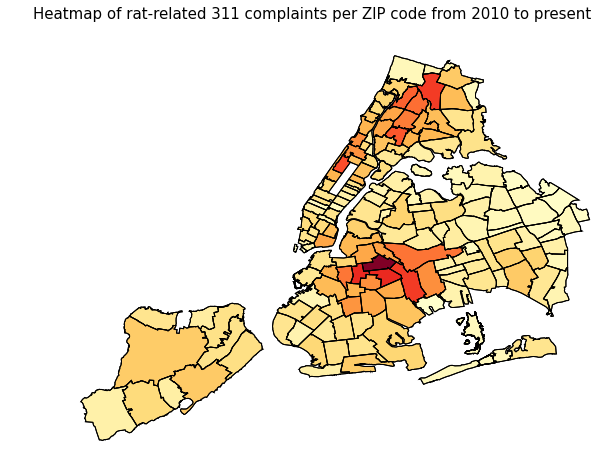

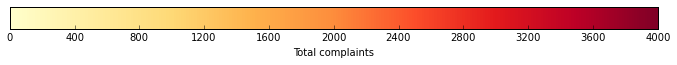

In [19]:
#Plotting heatmap of 311 complaints per zipcode
fig1 = pl.figure(figsize=(10, 10))
fig1 = nyc_map.plot(column='Total Complaints', alpha=1, colormap='YlOrRd')
fig1.axis('off')
pl.title("Heatmap of rat-related 311 complaints per ZIP code from 2010 to present", fontsize=15)

fig2 = pl.figure(figsize=(10, 2))
ax1 = fig2.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.YlOrRd
norm = mpl.colors.Normalize(vmin=0, vmax=4000)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='horizontal')
cb1.set_label('Total complaints')

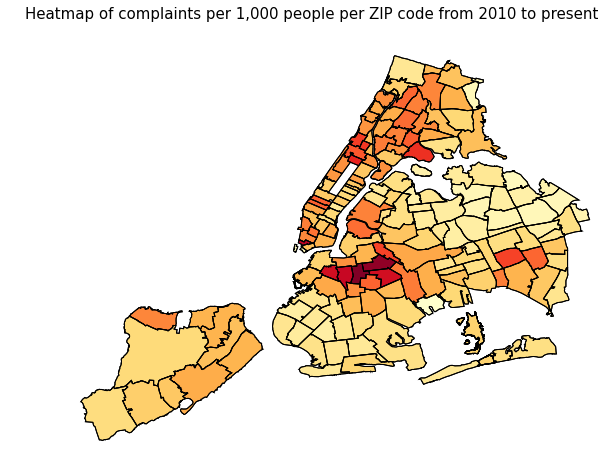

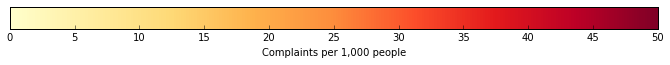

In [20]:
#Plotting heatmap of 311 complaints per zipcode
fig1 = pl.figure(figsize=(10, 10))
fig1 = nyc_map.plot(column='Complaints Per 1,000 People', alpha=1, colormap='YlOrRd')
fig1.axis('off')
pl.title("Heatmap of complaints per 1,000 people per ZIP code from 2010 to present", fontsize=15)

fig2 = pl.figure(figsize=(10, 2))
ax1 = fig2.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.YlOrRd
norm = mpl.colors.Normalize(vmin=0, vmax=50)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='horizontal')
cb1.set_label('Complaints per 1,000 people')

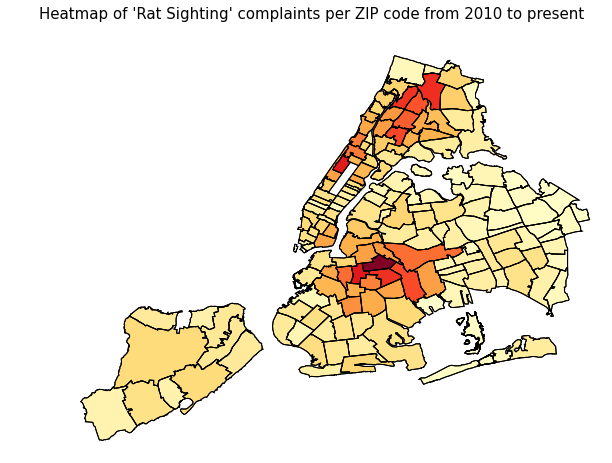

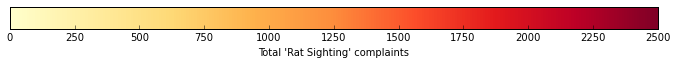

In [21]:
#Plotting heatmap of 311 complaints per zipcode
fig1 = pl.figure(figsize=(10, 10))
fig1 = nyc_map.plot(column='Rat Sighting', alpha=1, colormap='YlOrRd')
fig1.axis('off')
pl.title("Heatmap of 'Rat Sighting' complaints per ZIP code from 2010 to present", fontsize=15)

fig2 = pl.figure(figsize=(10, 2))
ax1 = fig2.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.YlOrRd
norm = mpl.colors.Normalize(vmin=0, vmax=2500)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='horizontal')
cb1.set_label("Total 'Rat Sighting' complaints")

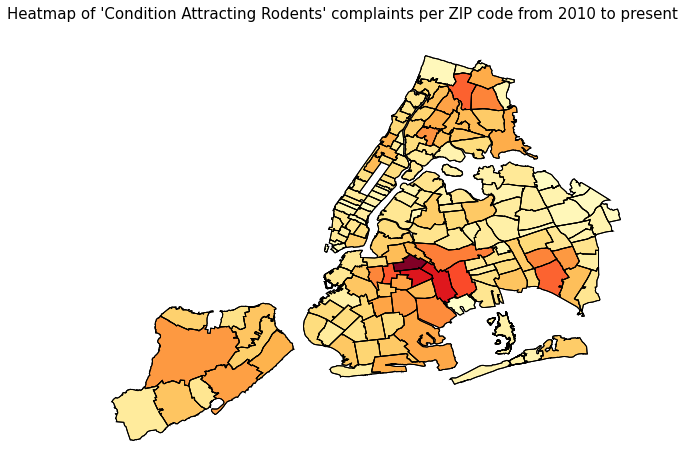

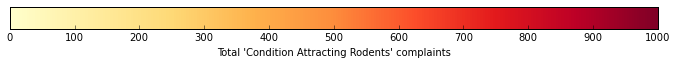

In [22]:
#Plotting heatmap of 311 complaints per zipcode
#Brooklyn/Queens inhabitants tend to be more vigilant about rats
fig1 = pl.figure(figsize=(10, 10))
fig1 = nyc_map.plot(column='Condition Attracting Rodents', alpha=1, colormap='YlOrRd')
fig1.axis('off')
pl.title("Heatmap of 'Condition Attracting Rodents' complaints per ZIP code from 2010 to present", fontsize=15)

fig2 = pl.figure(figsize=(10, 2))
ax1 = fig2.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.YlOrRd
norm = mpl.colors.Normalize(vmin=0, vmax=1000)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='horizontal')
cb1.set_label("Total 'Condition Attracting Rodents' complaints")

In [23]:
#Estimating linear model
X1 = df['Median Household Income']
Y1 = df['Total Complaints']

model1 = sm.OLS(Y1, sm.add_constant(X1), mising='drop').fit()
print model1.summary()
print model1.params

                            OLS Regression Results                            
Dep. Variable:       Total Complaints   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     32.02
Date:                Tue, 15 Dec 2015   Prob (F-statistic):           6.21e-08
Time:                        03:16:23   Log-Likelihood:                -1359.6
No. Observations:                 175   AIC:                             2723.
Df Residuals:                     173   BIC:                             2729.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
const                    1

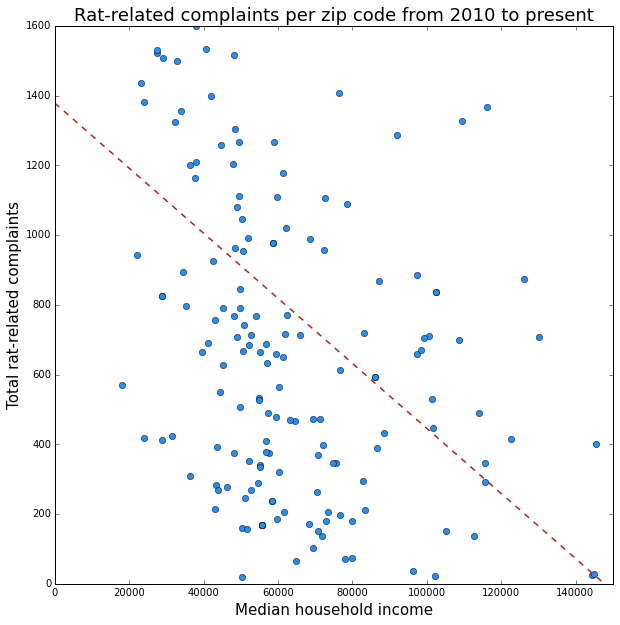

In [24]:
#Plotting linear model
#Problem: low-income neighborhoods tend to be more populous, which tends to increase the number of complaints
#So we're next doing the calculation with complaints per 1,000 people
pl.figure(figsize=(10, 10))
pl.plot(X1, Y1, 'o', color = 'dodgerblue')
xlim(0,150000)
ylim(0, 1600)
XLR1 = arange(0, 200000, 0.1)
YLR1 = model1.params[1]*XLR1+model1.params[0]
pl.plot(XLR1, YLR1, '--', linewidth = 1.50, color = 'firebrick')
pl.xlabel("Median household income", fontsize=15)
pl.ylabel("Total rat-related complaints", fontsize=15)
pl.title("Rat-related complaints per zip code from 2010 to present", fontsize=18)

In [25]:
#Estimating second degree linear model
model2 = smf.ols(formula = 'Y ~ X + I((X)) + I((X)**2)', 
        data={'X': df['Median Household Income'],'Y': df['Total Complaints']}).fit()
print model2.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     24.40
Date:                Tue, 15 Dec 2015   Prob (F-statistic):           4.70e-10
Time:                        03:16:25   Log-Likelihood:                -1352.6
No. Observations:                 175   AIC:                             2711.
Df Residuals:                     172   BIC:                             2721.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    2187.6189    239.045      9.151      

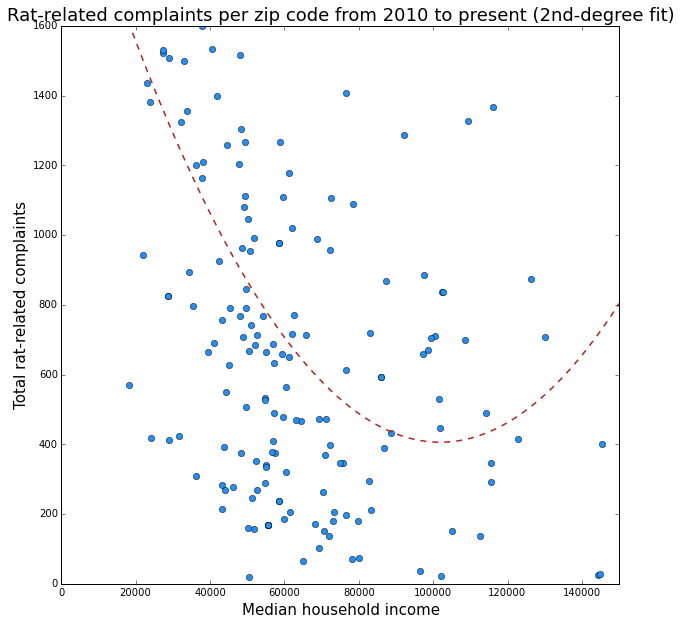

In [26]:
secdegree2 = np.polyfit(X1, Y1, 2)
fig2 = pl.figure(figsize=(10, 10))
pl.plot(X1, Y1, 'o', color = 'dodgerblue')
xlim(0,150000)
ylim(0, 1600)
XLR2 = arange(0, 200000, 0.1)
YLR2 = secdegree2[0]*XLR2**2+secdegree2[1]*XLR2+secdegree2[2]
pl.plot(XLR2, YLR2, '--', linewidth = 1.50, color = 'firebrick')
pl.xlabel("Median household income", fontsize=15)
pl.ylabel("Total rat-related complaints", fontsize=15)
pl.title("Rat-related complaints per zip code from 2010 to present (2nd-degree fit)", fontsize=18)

In [27]:
#Estimating linear model
#A problem of this approach is that higher populational density might drive rat complaints
X3 = df['Median Household Income']
Y3 = df['Complaints Per 1,000 People']

model3 = sm.OLS(Y3, sm.add_constant(X3), mising='drop').fit()
print model3.summary()
print model3.params

                                 OLS Regression Results                                
Dep. Variable:     Complaints Per 1,000 People   R-squared:                       0.043
Model:                                     OLS   Adj. R-squared:                  0.038
Method:                          Least Squares   F-statistic:                     7.855
Date:                         Tue, 15 Dec 2015   Prob (F-statistic):            0.00565
Time:                                 03:16:26   Log-Likelihood:                -628.97
No. Observations:                          175   AIC:                             1262.
Df Residuals:                              173   BIC:                             1268.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------

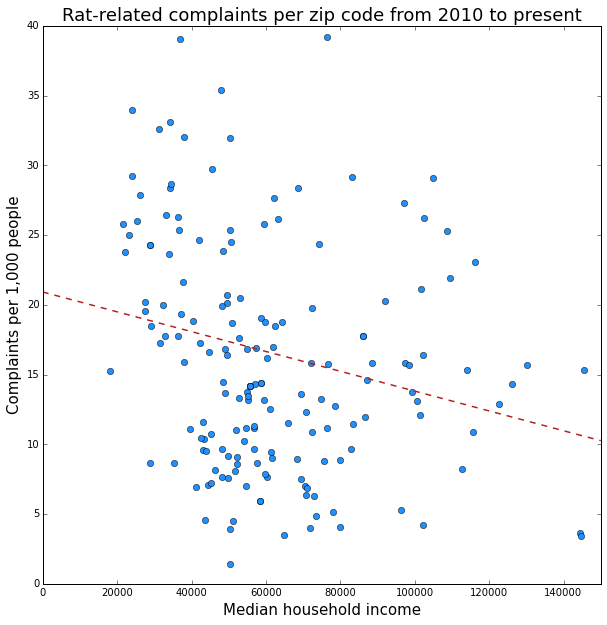

In [28]:
#Plotting linear model
pl.figure(figsize=(10, 10))
pl.plot(X3, Y3, 'o', color = 'dodgerblue')
xlim(0,150000)
ylim(0, 40)
XLR3 = arange(0, 200000, 0.1)
YLR3 = model3.params[1]*XLR3+model3.params[0]
pl.plot(XLR3, YLR3, '--', linewidth = 1.50, color = 'firebrick')
pl.xlabel("Median household income", fontsize=15)
pl.ylabel("Complaints per 1,000 people", fontsize=15)
pl.title("Rat-related complaints per zip code from 2010 to present", fontsize=18)

In [29]:
#Estimating second degree linear model
model4 = smf.ols(formula = 'Y ~ X + I((X)) + I((X)**2)', 
        data={'X': df['Median Household Income'],'Y': df['Complaints Per 1,000 People']}).fit()
print model4.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     8.706
Date:                Tue, 15 Dec 2015   Prob (F-statistic):           0.000250
Time:                        03:16:28   Log-Likelihood:                -624.42
No. Observations:                 175   AIC:                             1255.
Df Residuals:                     172   BIC:                             1264.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      31.0297      3.728      8.324      

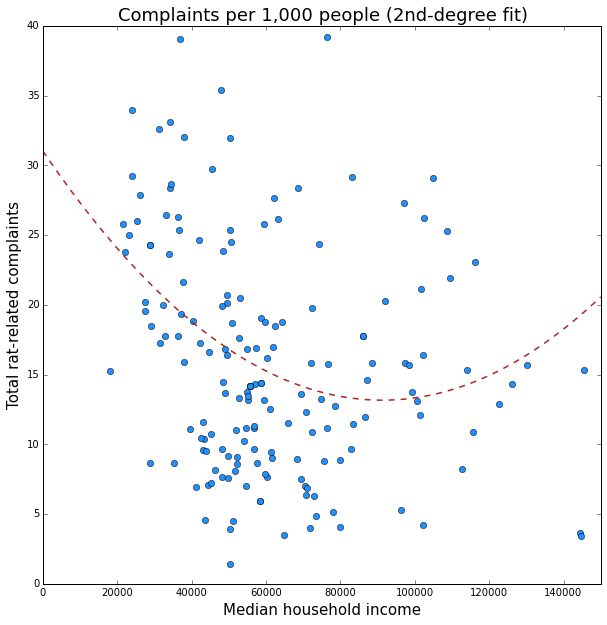

In [30]:
secdegree4 = np.polyfit(X3, Y3, 2)
fig4 = pl.figure(figsize=(10, 10))
pl.plot(X3, Y3, 'o', color = 'dodgerblue')
xlim(0,150000)
ylim(0, 40)
XLR4 = arange(0, 200000, 0.1)
YLR4 = secdegree4[0]*XLR4**2+secdegree4[1]*XLR4+secdegree4[2]
pl.plot(XLR4, YLR4, '--', linewidth = 1.50, color = 'firebrick')
pl.xlabel("Median household income", fontsize=15)
pl.ylabel("Total rat-related complaints", fontsize=15)
pl.title("Complaints per 1,000 people (2nd-degree fit)", fontsize=18)

In [31]:
#Top 5 Income Growth ZIPs
topg5 = df[['ZIP', 'Complaints Per 1,000 People', 'Income Growth']]
topg5['Income as % of NYC Avg'] = ["{:.2f}%".format(i) for i in topg5['Income Growth']/df['Income Growth'].mean()*100] 
topg5 = topg5.drop('Income Growth', 1)
topg5 = topg5.sort(['Complaints Per 1,000 People'], ascending=[False])
topg5.index = [i+1 for i in range(len(topg5))]
topg5 = topg5[topg5.index <= 5]
topg5

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,ZIP,"Complaints Per 1,000 People",Income as % of NYC Avg
1,11216,48.144193,365.48%
2,11221,46.492173,175.36%
3,10007,41.785919,120.80%
4,11238,40.842840,261.61%
5,11217,39.185084,214.46%


In [32]:
#Top 15 ZIPs
top15 = df[['ZIP', 'Complaints Per 1,000 People', 'Median Household Income']]
top15['Income as % of NYC Avg'] = ["{:.2f}%".format(i) for i in top15['Median Household Income']/df['Median Household Income'].mean()*100] 
top15 = top15.drop('Median Household Income', 1)
top15 = top15.sort(['Complaints Per 1,000 People'], ascending=[False])
top15.index = [i+1 for i in range(len(top15))]
top15 = top15[top15.index <= 15]
top15

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,ZIP,"Complaints Per 1,000 People",Income as % of NYC Avg
1,11216,48.144193,63.05%
2,11221,46.492173,55.96%
3,10007,41.785919,187.42%
4,11238,40.842840,101.97%
5,11217,39.185084,124.00%
6,11233,39.058655,59.87%
7,10026,35.408640,77.58%
8,10474,33.954890,39.08%
9,10030,33.112337,55.64%
10,10031,32.566710,50.84%


In [33]:
#Bottom 10 ZIPs
#Complaints >15
bottom15 = df[['ZIP', 'Complaints Per 1,000 People', 'Median Household Income']]
bottom15['Income as % of NYC Avg'] = ["{:.2f}%".format(i) for i in bottom15['Median Household Income']/df['Median Household Income'].mean()*100] 
bottom15 = bottom15.drop('Median Household Income', 1)
bottom15 =  bottom15[bottom15['Complaints Per 1,000 People']>2]
bottom15 = bottom15.sort(['Complaints Per 1,000 People'], ascending=[True])
bottom15.index = [i+1 for i in range(len(bottom15))]
bottom15 = bottom15[bottom15.index <= 15]
bottom15

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ZIP,"Complaints Per 1,000 People",Income as % of NYC Avg
1,10280,3.438176,234.78%
2,11360,3.495022,105.27%
3,10005,3.644008,234.05%
4,10475,3.909018,81.60%
5,11364,3.993633,116.53%
6,11362,4.095831,129.56%
7,10069,4.231583,165.58%
8,11354,4.500893,82.95%
9,11355,4.576632,70.78%
10,11365,4.875509,119.05%


In [35]:
#Estimating linear model
df_y = df[np.isfinite(df['YearBuilt'])]

X5 = df_y['YearBuilt']
Y5 = df_y['Complaints Per 1,000 People']

model5 = sm.OLS(Y5, sm.add_constant(X5), mising='drop').fit()
print model5.summary()
print model5.params

                                 OLS Regression Results                                
Dep. Variable:     Complaints Per 1,000 People   R-squared:                       0.175
Model:                                     OLS   Adj. R-squared:                  0.164
Method:                          Least Squares   F-statistic:                     16.93
Date:                         Tue, 15 Dec 2015   Prob (F-statistic):           9.35e-05
Time:                                 03:17:47   Log-Likelihood:                -297.10
No. Observations:                           82   AIC:                             598.2
Df Residuals:                               80   BIC:                             603.0
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------

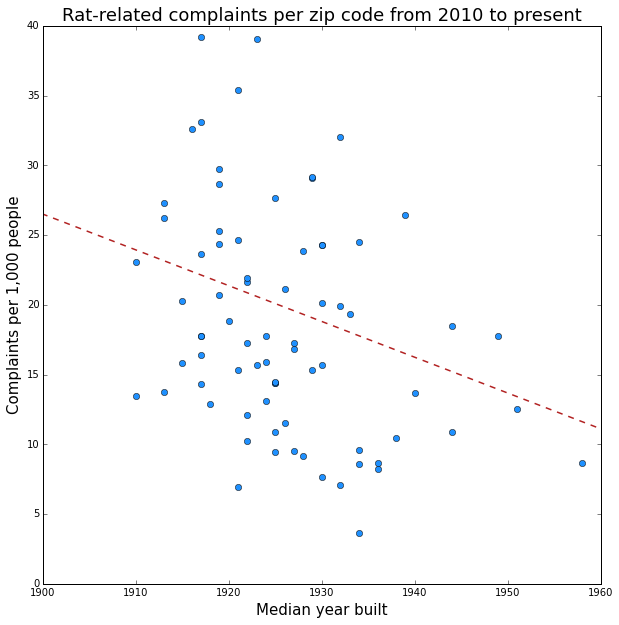

In [36]:
#Plotting linear model
pl.figure(figsize=(10, 10))
pl.plot(X5, Y5, 'o', color = 'dodgerblue')
xlim(1900,1960)
ylim(0, 40)
XLR5 = arange(0, 200000, 0.1)
YLR5 = model5.params[1]*XLR5+model5.params[0]
pl.plot(XLR5, YLR5, '--', linewidth = 1.50, color = 'firebrick')
pl.xlabel("Median year built", fontsize=15)
pl.ylabel("Complaints per 1,000 people", fontsize=15)
pl.title("Rat-related complaints per zip code from 2010 to present", fontsize=18)

In [37]:
#Estimating second degree linear model
model6 = smf.ols(formula = 'Y ~ X + I((X)) + I((X)**2)', 
        data={'X': df_y['YearBuilt'],'Y': df_y['Complaints Per 1,000 People']}).fit()
print model6.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     8.554
Date:                Tue, 15 Dec 2015   Prob (F-statistic):           0.000434
Time:                        03:17:48   Log-Likelihood:                -296.94
No. Observations:                  82   AIC:                             599.9
Df Residuals:                      79   BIC:                             607.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    4880.7334   7703.696      0.634      

In [47]:
#Estimating linear model
X8 = df['Income Growth']
Y8 = df['Complaints 2014-15 Per 1,000 People']

model8 = sm.OLS(Y8, sm.add_constant(X8), mising='drop').fit()
print model8.summary()
print model8.params

                                     OLS Regression Results                                    
Dep. Variable:     Complaints 2014-15 Per 1,000 People   R-squared:                       0.074
Model:                                             OLS   Adj. R-squared:                  0.068
Method:                                  Least Squares   F-statistic:                     13.79
Date:                                 Tue, 15 Dec 2015   Prob (F-statistic):           0.000276
Time:                                         03:32:39   Log-Likelihood:                -479.56
No. Observations:                                  175   AIC:                             963.1
Df Residuals:                                      173   BIC:                             969.4
Df Model:                                            1                                         
Covariance Type:                             nonrobust                                         
                    coef    std err     

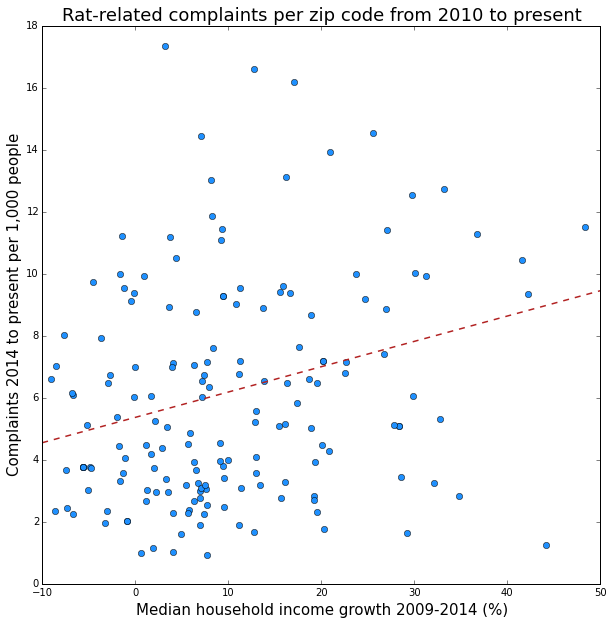

In [39]:
#Plotting linear model
#http://citylimits.org/2013/02/27/debate-over-size-of-brooklyns-rat-problem-what-to-do-about-it/
pl.figure(figsize=(10, 10))
pl.plot(X8, Y8, 'o', color = 'dodgerblue')
xlim(-10, 50)
ylim(0, 18)
XLR8 = arange(-10, 100, 0.1)
YLR8 = model8.params[1]*XLR8+model8.params[0]
pl.plot(XLR8, YLR8, '--', linewidth = 1.50, color = 'firebrick')
pl.xlabel("Median household income growth 2009-2014 (%)", fontsize=15)
pl.ylabel("Complaints 2014 to present per 1,000 people", fontsize=15)
pl.title("Rat-related complaints per zip code from 2010 to present", fontsize=18)

In [40]:
#Estimating second degree linear model
model6 = smf.ols(formula = 'Y ~ X + I((X)) + I((X)**2)', 
        data={'X': df['Income Growth'],'Y': df['Complaints 2014-15 Per 1,000 People']}).fit()
print model6.summary()

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     6.861
Date:                Tue, 15 Dec 2015   Prob (F-statistic):            0.00136
Time:                        03:17:48   Log-Likelihood:                -479.55
No. Observations:                 175   AIC:                             965.1
Df Residuals:                     172   BIC:                             974.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       5.3664      0.358     14.987      

In [48]:
#Estimating linear model
X9 = df['Median Household Income 2014']
Y9 = df['Complaints 2014-15 Per 1,000 People']

model9 = sm.OLS(Y8, sm.add_constant(X8), mising='drop').fit()
print model9.summary()
print model9.params

                                     OLS Regression Results                                    
Dep. Variable:     Complaints 2014-15 Per 1,000 People   R-squared:                       0.074
Model:                                             OLS   Adj. R-squared:                  0.068
Method:                                  Least Squares   F-statistic:                     13.79
Date:                                 Tue, 15 Dec 2015   Prob (F-statistic):           0.000276
Time:                                         03:33:15   Log-Likelihood:                -479.56
No. Observations:                                  175   AIC:                             963.1
Df Residuals:                                      173   BIC:                             969.4
Df Model:                                            1                                         
Covariance Type:                             nonrobust                                         
                    coef    std err     

In [41]:
#Creating time series with complaints
ts_311 = data_311
ts_311['Created Date'] =  pd.to_datetime(ts_311['Created Date'])
ts_311 = ts_311.set_index('Created Date')
ts_311.index.name = None 
ts_311 = ts_311.groupby(pd.TimeGrouper("M")).resample("M", how='count')
ts_311 = ts_311[['Unique Key']]
ts_311['Date'] = [ts_311.index[i][0] for i in range(len(ts_311))]
ts_311.index = range(len(ts_311))
ts_311 = ts_311.rename(columns = {'Unique Key':'Total Complaints'})
ts_311 = ts_311[ts_311.index < 71]
ts_311['Month'] = pd.DatetimeIndex(ts_311['Date']).month
ts_311['Year'] = pd.DatetimeIndex(ts_311['Date']).year
ts_311_10 = ts_311[ts_311['Year'] == 2010]
ts_311_11 = ts_311[ts_311['Year'] == 2011]
ts_311_12 = ts_311[ts_311['Year'] == 2012]
ts_311_13 = ts_311[ts_311['Year'] == 2013]
ts_311_14 = ts_311[ts_311['Year'] == 2014]
ts_311_15 = ts_311[ts_311['Year'] == 2015]
ts_311_10.head()

,Total Complaints,Date,Month,Year
0,1256,2010-01-31,1,2010
1,1014,2010-02-28,2,2010
2,1695,2010-03-31,3,2010
3,1857,2010-04-30,4,2010
4,2085,2010-05-31,5,2010


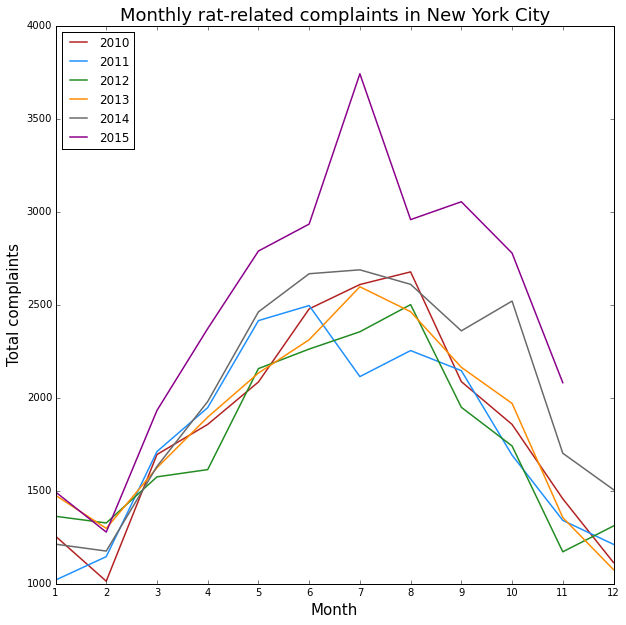

In [42]:
#https://www.washingtonpost.com/local/the-gripe-rats-in-dc-are-a-sign-of-summer/2013/08/07/32be9cf4-fe9f-11e2-bd97-676ec24f1f3f_story.html
#http://animaldiversity.org/accounts/Rattus_norvegicus/
#http://www.unitedstateszipcodes.org/
pl.figure(figsize=(10, 10))
pl.plot(ts_311_10['Month'], ts_311_10['Total Complaints'], '-', linewidth = 1.50, color = 'firebrick', label = '2010')
pl.plot(ts_311_11['Month'], ts_311_11['Total Complaints'], '-', linewidth = 1.50, color = 'dodgerblue', label = '2011')
pl.plot(ts_311_12['Month'], ts_311_12['Total Complaints'], '-', linewidth = 1.50, color = 'forestgreen', label = '2012')
pl.plot(ts_311_13['Month'], ts_311_13['Total Complaints'], '-', linewidth = 1.50, color = 'darkorange', label = '2013')
pl.plot(ts_311_14['Month'], ts_311_14['Total Complaints'], '-', linewidth = 1.50, color = 'dimgrey', label = '2014')
pl.plot(ts_311_15['Month'], ts_311_15['Total Complaints'], '-', linewidth = 1.50, color = 'darkmagenta', label = '2015')
pl.xticks(range(1, 13, 1))
pl.legend(loc='upper left')
xlim(1, 12)
pl.xlabel("Month", fontsize=15)
pl.ylabel("Total complaints", fontsize=15)
pl.title("Monthly rat-related complaints in New York City", fontsize=18)

In [43]:
#Grouping per year_zip
ts_311_year = ts_311.groupby(['Year']).sum()
ts_311_year = ts_311_year[['Total Complaints']]
ts_311_year.index.name = None
ts_311_year

,Total Complaints
2010,22186
2011,21494
2012,21327
2013,22365
2014,24515
2015,27412


([<matplotlib.axis.XTick at 0x1783c70d0>,
 <a list of 6 Text xticklabel objects>)

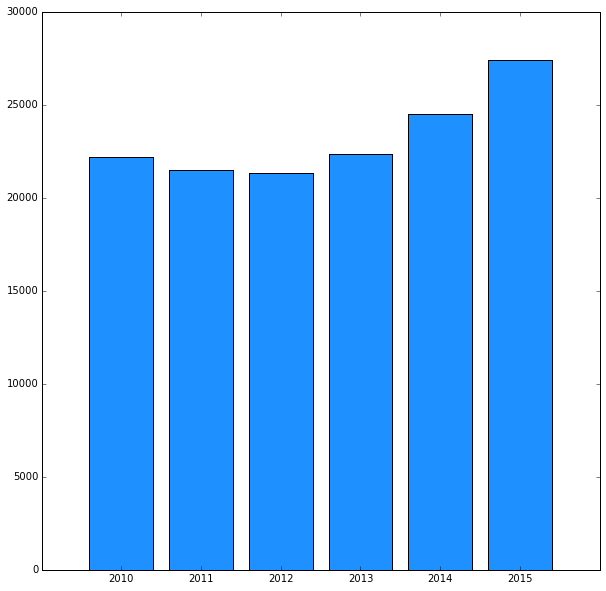

In [44]:
pl.figure(figsize=(10, 10))
pl.bar(ts_311_year.index, ts_311_year['Total Complaints'], align="center", color='dodgerblue')   
pl.xticks(ts_311_year.index, ts_311_year.index)